# PW 2 - Bayesian analysis with MRF
For this part we will perform the binary classification of a grayscale image **_Iobservee_** (image of the observations, realization $y$ of the field $Y$) using a Markovian model. 

In this ideal case, we are given the ideal solution $x$ (binary image **_IoriginalBW_**), realization of the field of classes $X$, which will be used to evaluate the quality of the solution $\hat{x}$ that we will have obtained. (NB: In practice usually, we don't have access to $x$). 

In this part we will use the **_display_** function to visualize the images.

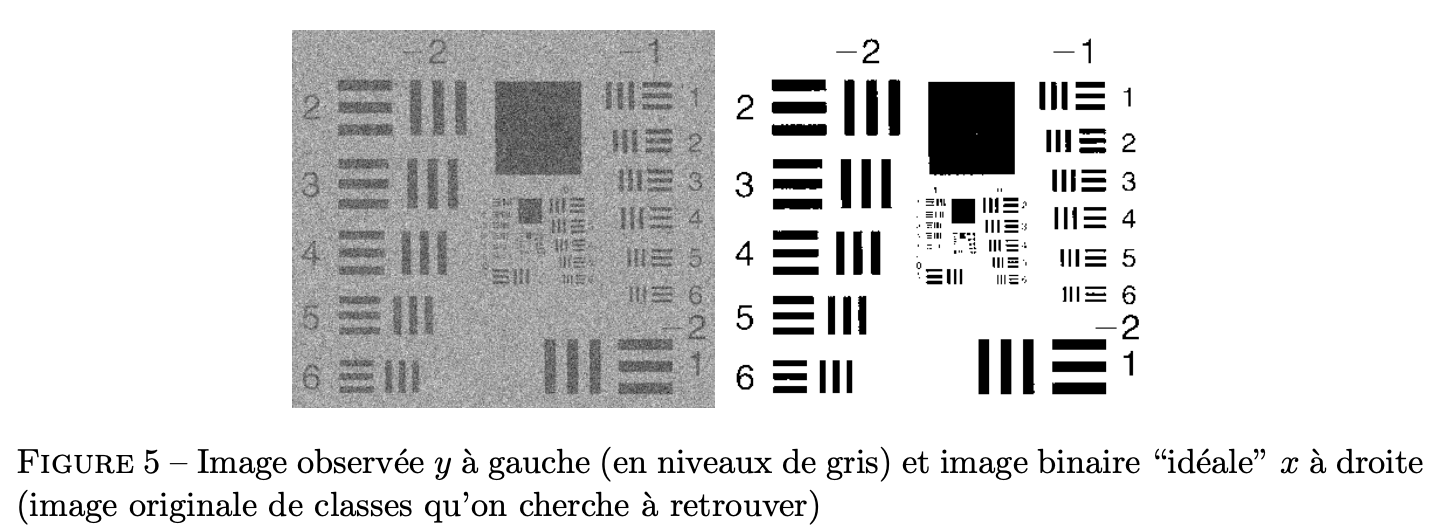

In [53]:
import math
import random
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
import imageio
from scipy import ndimage as ndi
from skimage import io

from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.io import output_notebook
output_notebook()

In [54]:
def affiche_pour_colab(im,MINI=None, MAXI=None,titre=''): #special colab, don't look
  def normalise_image_pour_bokeh(X,MINI,MAXI):
    if MAXI==None:
      MAXI = np.max(X)
    if MINI==None:
      MINI = np.min(X)
    imt=np.copy(X.copy())
    imt=(np.clip(imt,MINI,MAXI)/(MAXI-MINI))
    imt[imt<0]=0
    imt[imt>1]=1
    imt*=255
    sortie=np.empty((*imt.shape,4),dtype=np.uint8)
    for k in range(3):
      sortie[:,:,k]=imt
    sortie[:,:,3]=255
    return sortie

  img = im
  img=normalise_image_pour_bokeh(np.flipud(im),MINI,MAXI)
  p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], y_range=[im.shape[0], 0], x_range=[0, im.shape[1]])
  # p.x_range.range_padding = p.y_range.range_padding = 0
  # must give a vector of images
  p.image(image=[np.flipud(im)], x=0, y=im.shape[0], dw=im.shape[1], dh=im.shape[0], palette="Greys9", level="image")
  p.xgrid.visible = False
  p.ygrid.visible = False
  showbokeh(p)

def affiche(im,MINI=0.0, MAXI=None,titre='',printname=False):
  affiche_pour_colab(im,MINI=MINI, MAXI=MAXI,titre=titre) # under google colab many options disappear

The scikit-image library allows to read images from a URL. The "display" function allows to access directly to the grey levels and to the pixels positions by using the mouse.

In [55]:
im_obs=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/Iobservee.png")

affiche(im_obs)

In [56]:
im_ori=imageio.imread('https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/IoriginaleBW.png')

affiche(im_ori)

The objective is to estimate $x$ from y using a prior on $P(X)$ in the form of a Markovian model. 
We note $x_s$ the class of the pixel $s$ (that we are looking for), and $y_s$ the observed gray level. The objective is to use a global model on the random field $X$ to classify the image. As we have seen in class, this amounts to minimizing the following energy:

$$U(x|y)=\sum_s -ln(P(Y_s=y_s |X_s=x_s))+\sum_c U_c(x_s, s\in c)$$ 

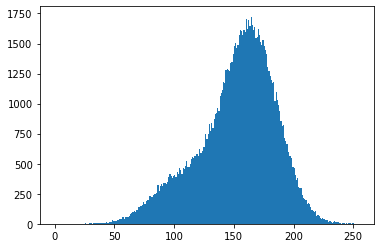

In [57]:
#study of the global distribution of the image
#display of the histogram of the image 
plt.figure()
plt.hist(im_obs.ravel(),range=[0,np.max(im_obs)],bins=np.max(im_obs))
plt.show()

## 1. Analysis of the gray level distributions
In this part, we learn the probabilities $P(Y_s=y_s |X_s)$, that is to say $P(Y_s=y_s |X_s=0)$ and $P(Y_s=y_s |X_s=1)$. This is equivalent to studying the histogram of gray levels of pixels that are in class 0 and pixels that are in class 1.  


To perform this training, we need to select pixels belonging to class 0 on the one hand (dark area of the observed image), and pixels belonging to class 1 on the other hand (light area of the observed image). 

We can select pixels manually, using the command `v0=I[i1:i2,j1:j2]` in Python which puts in a vector all the values of the pixels of the image $I$ included between the indices $i1$ and $i2$ (rows), and $j1$ and $j2$ (columns).

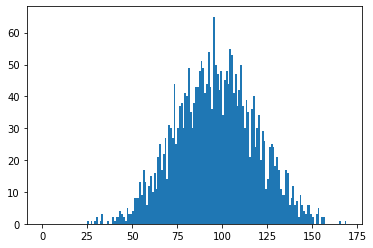

In [58]:
#select a small window in a dark region of the image (class 0)
#be careful, the ordinates correspond to the rows and the abscissas to the columns
crop_classe0=im_obs[50:100, 175:230]

#visualise the window
affiche(crop_classe0)
#plot its histogram
plt.figure()
plt.hist(crop_classe0.ravel(),range=[0,np.max(crop_classe0)],bins=np.max(crop_classe0))
plt.show()

In [59]:
#calculate its mean and variance
#
# By default, np.mean, np.zzz takes the two axes of the image. 
# You have to force the option if you want to do the average in row or in column
# use np.mean and np.var
m0=np.mean(crop_classe0)
var0= np.var(crop_classe0)

print(m0)
print(var0)

96.13490909090909
495.36398135537195


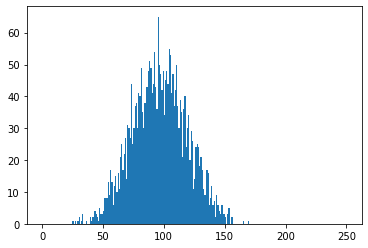

In [60]:
#select a small window in a dark region of the image (class 1)
crop_classe1=im_obs[230:300,130:200]
#plot its histogram
plt.figure()
plt.hist(crop_classe0.ravel(),range=[0,np.max(crop_classe1)],bins=np.max(crop_classe1))
plt.show()

In [61]:
#calculate its mean and variance
m1=np.mean(crop_classe1)
var1= np.var(crop_classe1)


print(m1)
print(var1)

163.87755102040816
512.7315368596419


### Q1
What are the distributions followed by the grey levels in these two classes? Give the means and variances of the two classes that you have estimated. 

### A1
The the grey levels in these two classes follow gaussian distributions(as we can also see in the graph), they mean and variance are respectively:

$μ_{0}$= 96.13490909090909 and $\sigma_{0}^2$= 495.36398135537195 

$μ_{1}$= 163.87755102040816 and $\sigma_{1}^2$= 512.7315368596419 


In [62]:
sigm1=np.sqrt(var0)
print(sigm1)
sigm2=np.sqrt(var1)
print(sigm2)

22.256773830799737
22.64357606164808


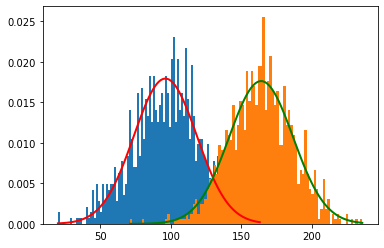

In [63]:
s0 = np.random.normal(m0, sigm1, 1000)
count, bins, ignored = plt.hist(s0, 100, density=True)
s00=1/(sigm1 * np.sqrt(2 * np.pi)) * np.exp( - (bins - m0)**2 / (2 * var0)) 
plt.plot(bins,s00,
         linewidth=2, color='r')
s1 = np.random.normal(m1, sigm2, 1000)
count, bins, ignored = plt.hist(s1, 100, density=True)
s11=1/(sigm2 * np.sqrt(2 * np.pi)) * np.exp( - (bins - m1)**2 / (2 * var1)) 
plt.plot(bins,s11,
         linewidth=2, color='g')
plt.show()


### Q2
In the following, the variances will be assumed to be equal in order to simplify the energy expressions. 

Suppose that we do not use a Markov model on $X$ and that we classify a pixel only according to its grey level by comparing $P(Y_s=y_s |X_s=0)$ and $P(Y_s=y_s |X_s=1)$. Show that this amounts to thresholding the image and give the value of the optimal threshold as a function of the parameters found previously (we say that we are doing a classification by punctual maximum likelihood).

### A2

We need to find the intersection of the two gaussian to find the perfect threshoold.
The gaussian equation is : $f(x)=\frac{1}{σ\sqrt{2π}}*e^{-\frac{(x-μ)^2}{2σ^2}}$

Since we have two distribution: 

$f_{0}(x)=\frac{1}{σ_{0}\sqrt{2π}}*e^{-\frac{(x-μ_{0})^2}{2{σ_{0}}^2}}$

$f_{1}(x)=\frac{1}{σ_{1}\sqrt{2π}}*e^{-\frac{(x-μ_{1})^2}{2{σ_{1}}^2}}$

We need to egualiate them to find teh intersection:  
$\frac{1}{σ_{0}\sqrt{2π}}*e^{-\frac{(x-μ_{0})^2}{2{σ_{0}}^2}}$= 
$\frac{1}{σ_{1}\sqrt{2π}}*e^{-\frac{(x-μ_{1})^2}{2{σ_{1}}^2}}$

Since $σ_{0}$ and $σ_{1}$ are very similar, we can consider them the same $σ_{0}= σ_{1}=σ$ and multiply for both side by $\frac{1}{σ\sqrt{2π}}$:  
$e^{-\frac{(x-μ_{0})^2}{2{σ_{0}}^2}}$ = $e^{-\frac{(x-μ_{1})^2}{2{σ_{1}}^2}}$

Applying the logaritm: 
$-\frac{(x-μ_{0})^2}{2{σ}^2}$ = $-\frac{(x-μ_{1})^2}{2{σ}^2}$

We can eliminate the minus and, once again, the denominator:

 $(x-μ_{0})^2$ = $(x-μ_{1})^2 $
 
 $ x^2 + μ_{0}^2 -2xμ_{0} = x^2 + μ_{1}^2 - 2xμ_{1} $

$  2xμ_{1}-2xμ_{0} =  μ_{1}^2 - μ_{0}^2  $

$x = \frac{μ_{1}^2 - μ_{0}^2}{2(μ_{1} - μ_{0})}$

Opening the numerator we obtain

$x = \frac{(μ_{1} - μ_{0})(μ_{1} + μ_{0})}{2(μ_{1} - μ_{0})}$ 

$x = \frac{(μ_{1} + μ_{0})}{2}$

The best threshoold is indeed in the middle between the mean of the two distribution! 

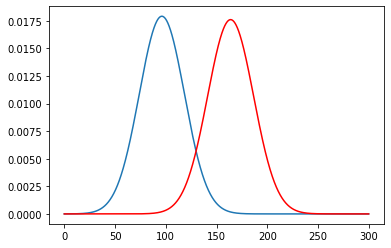

In [64]:
import scipy
from scipy import stats

x_values = np.arange(0,300, 0.1)
y_values = scipy.stats.norm(m0, sigm1)
x_values1 = np.arange(0,300, 0.1)
y_values1 = scipy.stats.norm(m1, sigm2)
plt.plot(x_values, y_values.pdf(x_values))
plt.plot(x_values1, y_values1.pdf(x_values),'r')



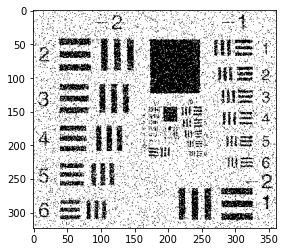

In [65]:
# Set the threshold for classification in the ML sense and display the image
threshold=(m1+m0)/2
im_bin=im_obs.copy()

im_mask=im_obs>threshold
#print(im_mask)
im_bin[~im_mask]=0 # if im mask==False->im_bin==0
im_bin[im_mask]=1 # if im_mask==True->im_bin==1
#print(im_bin)
im_thresh=im_bin.copy()
plt.figure()
plt.imshow(im_thresh,cmap='gray');  


###Q3
From the results found for $P(Y_s=y_s |X_s)$, write the likelihood energy (data attachment): $$U_{attdo}=\sum_s -ln(P(Y_s=y_s |X_s=x_s))$$ 

###A3

$$U_{attdo}=\sum_{s\in S}\frac{(y_s-y_{xs})^2}{2\sigma^2}+ ln(\sigma)$$ 

## 2 Ising model for regularisation and energies
To improve the thresholding results, it is necessary to introduce a regularisation (global prior model).

### Q4
Consider the function $\Delta(x_s,x_t)=0$ if $x_s=x_t$, and $\Delta(x_s,x_t)=1$ otherwise. Write the second-order clique potential for this Ising model as a function of $\Delta(x_s,x_t)$ where $x_s$ and $x_t$ are the classes of neighbouring pixels $s$ and $t$ in 4-connexity and the regularisation parameter $\beta$. This model will be 0 when the two neighbouring pixels are equal and $+\beta$ otherwise. 
Write the global energy of the whole field and the local conditional energy for a site 𝑠 using the results previously established for the data attachment energy and the regularization energy defined previously. 

Reminder: the global energy contains all the cliques in the image, the local conditional energy at a site 𝑠 contains only the cliques that contain 𝑠.

Tip: the energy is defined to within one additive constant and one multiplicative constant (the minimum of K+K'U is equivalent to the minimum of U). It is better to simplify the writing of the energy as much as possible in order to do the programming afterwards.

### A4
- _global energy_: 

$$U(x|y)=\sum_{s\in S}\frac{(y_s-y_{xs})^2}{2\sigma^2}+ ln(\sigma)+\beta\sum_{c={s,t}}Δ(x_s,x_t)$$ 

- _local conditional energy_:

$$U(x_s|y_s)=\frac{(y_s-y_{xs})^2}{2\sigma^2}+ ln(\sigma)+\beta\sum_{c={s,t(t\in V_s)}}Δ(x_s,x_t)$$ 



### Q5
Write the local conditional energies for classes 0 and 1 of the central pixel, using the following local neighbourhood configuration: neighbours in states 0, 1, 1, 1, and assuming that the grey level of the pixel is $y_s=105$, and using the mean and variance values found previously.

### A5 

$μ_{0}$= 96.13490909090909 and $\sigma_{0}^2$= 495.36398135537195 

$μ_{1}$= 163.87755102040816 and $\sigma_{1}^2$= 512.7315368596419 

Since the two variance are similar, we are not going to consider the ln(σ) in the computation.

Initialization step: 

$x_{s}=Class0:\frac{(105-96.13)^2}{2*495.36}=0,079$

$x_{s}=Class1:\frac{(105-163.88)^2}{2*512.73}=3,380$

ICM step: 

$U(Class0,y_{S})=0,079+3\beta$

$U(Class1,y_{S})=3,380+\beta$




### Q6
In which class will this pixel be put if it is assigned the class that locally minimises energy?

### A6

Depends on the value of $\beta: $

$0,079+3\beta < 3,380+\beta$

$\beta < 1,65$

Untill $\beta < 1,65$, $Class0$ is the one with lower energy, and greater probability, when $\beta > 1,65$, $Class1$ is the one with lower energy and greater probability!


### Q7
Considering the ***global*** energy of the field, what is the solution $x$ when $\beta$ is 0 ?

### A7
$$U(x|y)=\sum_{s\in S}\frac{(y_s-y_{xs})^2}{2\sigma^2}+ ln(\sigma)+\beta\sum_{c={s,t}}Δ(x_s,x_t)$$ with $\beta=0$

$$U(x|y)=\sum_{s\in S}\frac{(y_s-y_{xs})^2}{2\sigma^2}+ ln(\sigma)$$

We are not considering the neighboor pixels, it only depends on the likelihood and not on the prior! 

Some noise will remain in the final result since the white background will be perturbated by black noise and the black objects will be perturbated by white noise.

In this case considering a ***local*** energy, the winner would be $Class0$, since it's enery is lower with a $\beta=0$ .

### Q8
Considering the ***global*** energy of the field, what is the solution $x$ when $\beta$ is $+\infty$ ?

### A8
$$U(x|y)=\sum_{s\in S}\frac{(y_s-y_{xs})^2}{2\sigma^2}+ ln(\sigma)+\beta\sum_{c={s,t}}Δ(x_s,x_t)$$ with $\beta\to \infty$ we are increasing the power of $\beta: $

$$U(x|y)=\beta\sum_{c={s,t}}Δ(x_s,x_t)$$


We are only considering the neighboor pixels, it only depends on the prior and not on the likelihood, we end up only having  regularisation as in the first practical.

In our case $Class1$ will be the "winning class", and as a consequence, we will have much more white in the image. We will see in the practical that the best $\beta$ is going to be around 2000, but after that value, the result "saturate". 

In this case considering a ***local*** energy, the winner would be $Class1$, since it's enery is lower with a $\beta\to\infty$ .



### Q9
How will the solution vary when $\beta$ increases ? Comment on the interest of this Markovian model. 

### A9

If $\beta$ increase, we are giving more and more decision power to the neighboors, so we are considering more the prior than the likelihood, in our casee if $\beta>1,65$ the winning class would be $Class1$

## 3. Optimisation by ICM algorithm
We will optimise the global energy defined above, using the ICM (Iterated Conditional Modes) algorithm which consists of minimising the local conditional energy of the pixels one after the other, starting from a good initialisation of the classes. This algorithm converges to a local minimum but is very fast.  
 
Complete the **iter_icm** function to program the ICM, taking into account the data attachment term you have learned.

### ICM function 
Using what you did for the Gibbs sampler, complete the following function to perform one iteration of the Iterated Conditional Modes algorithm (one pass over all pixels in the image). 

In [66]:
def iter_icm(im_bin,im_toclass,beta_reg,m0,m1):

    i=0;
    j=0;

    for i in range(im_bin.shape[0]):
        for j in range(im_bin.shape[1]):
            # do not change these indices they allow access to neighboring pixels  
            i1=(i-1)%im_bin.shape[0]
            i2=(i+1)%im_bin.shape[0]
            j1=(j-1)%im_bin.shape[1]
            j2=(j+1)%im_bin.shape[1]

            # energy computation if the pixel is put in class 0
            Ureg0=beta_reg*(im_bin[i, j1]+im_bin[i, j2]+im_bin[i1, j]+im_bin[i2, j])
            Uattdo0=(im_toclass[i, j]-m0)**2;
            U0=Uattdo0+Ureg0;

            # energy computation if the pixel is put in class 1
            Ureg1=beta_reg*(4-(im_bin[i, j1]+im_bin[i, j2]+im_bin[i1, j]+im_bin[i2, j]))
            Uattdo1=(im_toclass[i, j]-m1)**2;
            U1=Uattdo1+Ureg1;
            if (U0<U1):
                im_bin[i,j]= 0
            else :
                im_bin[i,j]= 1

    return im_bin

### Q10
What do you suggest to have a good initialization of the solution? Justify your answer.

###A10

We can use the thresholded image that we calculate before applying the intersection of the two gaussians, in this way we will have a binary image, closer to the correct result and more different from the noisy one!

Implement the ICM and study the influence of $\beta$.

Value for obtaining a beta_reg=2000

In [67]:
s= 2000/((var0)*2)
print(s)

2.018717625096372


2000.0


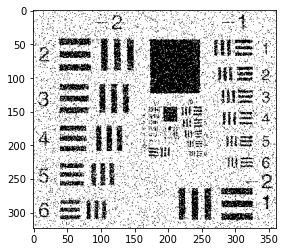

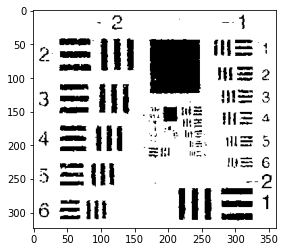

In [68]:
# ICM algorithm to be implemented
#define the value of beta_reg to have a "good" regularization
beta_reg=2*(var0)*s
print(beta_reg)
#initialise the binary image of the classes 
im_bin = im_thresh.copy()#binary one 
mafigure=plt.figure()
plt.imshow(im_bin,cmap='gray');        
plt.show() 

affiche(im_bin)
# program a loop in which we call iter_icm 
# and display the class image as iterations are performed 
for n in range(40):
   im_bin = iter_icm(im_bin,im_obs,beta_reg,m0,m1) 
plt.figure()
plt.imshow(im_bin,cmap='gray');
plt.show()

### Q12
With what value of $\beta$ do you get a good solution (i.e. the closest to the given "ideal" image **IoriginaleBW.png**). Compare this result with the result of the optimal thresholding.


###A12
(here when i write $\beta$ i mean the final $\beta\_reg=2*\sigma^2*\beta'$)

With $\beta=100$:

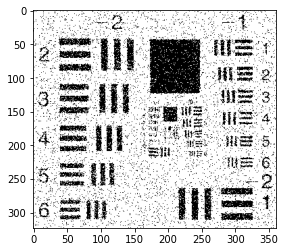

With $\beta$=1000

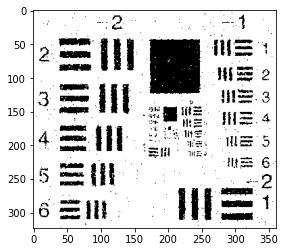

With $\beta$=-1000

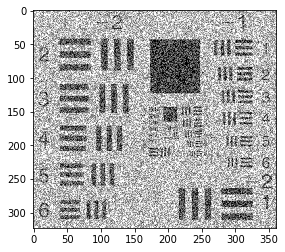

With $\beta=0.5$

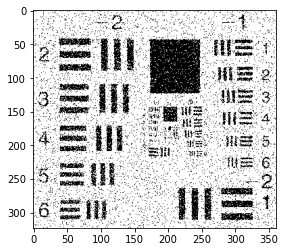

With $\beta=0$

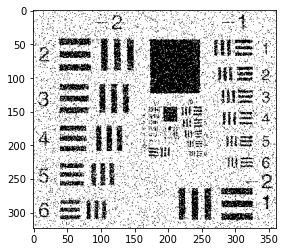

With $\beta=2000$ (we will see that this is the best value) : 

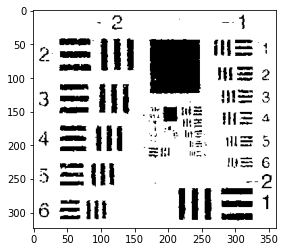

Comparing this results with the image calculated with the optimal thresholding:

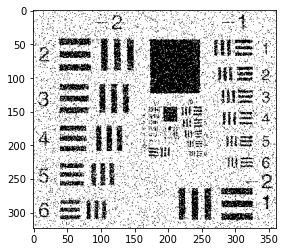

Our new image is clearly less noisy than our initial result!

You can compare your result with the original image to find the right regularisation parameter. 

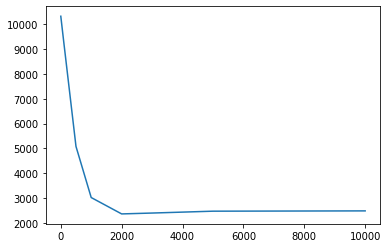

In [69]:
#use np.abs to calculate the absolute value of the difference 
# between the original binary image and the ICM result
# note: im_bin is coded between 0 and 1 and im_ori between 0 and 255
whites=[]
beta=[1,100,500,1000,2000,3000,5000,10000]
for beta_reg in beta:
  for n in range(10):
    im_bin = iter_icm(im_bin,im_obs,beta_reg,m0,m1) 
  ima_diff=np.abs(im_bin-im_ori/255)
  nb_white=np.where(ima_diff==1,1,0).sum()#sum up all the white pixels too see how much is the difference between the two images
  whites.append(nb_white)
plt.plot(np.array(beta),np.array(whites))
#At 2000 we find the minimum, at least between the value that i used. 
#[10320, 9266, 5082, 3025, 2366, 2401, 2476, 2488]

affiche(ima_diff)

In [34]:
print(whites)

[10320, 9266, 5082, 3025, 2366, 2401, 2476, 2488]


### Q13
Try with other initialisations (with a constant image, with a random image). Comment on their influence.

###A13

As we saw in the course, ICM algorithm is a deterministic algorithm, the result strongly depends on the initialization,with $\beta$=5000.

Using as initialisation a random image: 

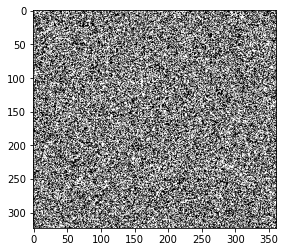

The result was :

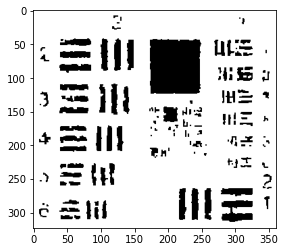

With a black image : 

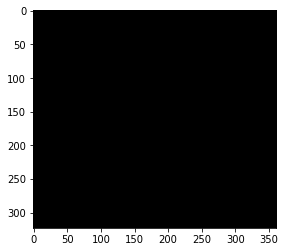

The result was :

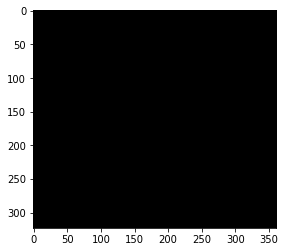

With a white image : 

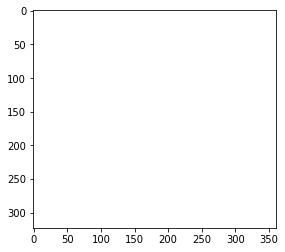

The result was : 

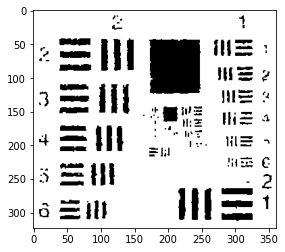

With $\beta$=2000

Noisy initialization:

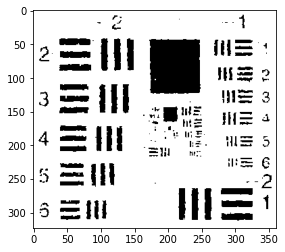

White initialization: 

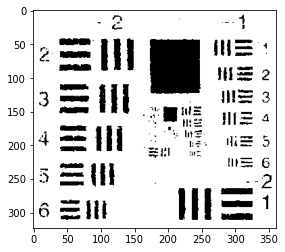

Black initialization: 

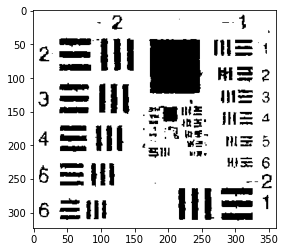

With $\beta$=100

Noisy initialization: 

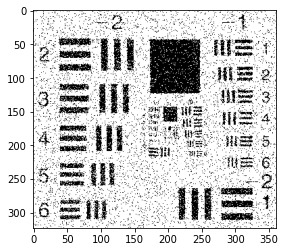

White initialization: 

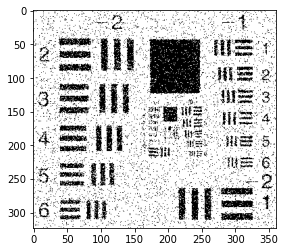

Black initialization: 

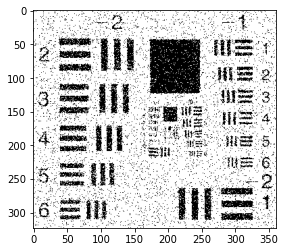

<Figure size 432x288 with 0 Axes>

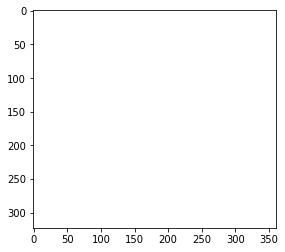

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in ubyte_scalars


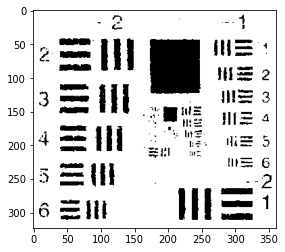

In [41]:
from PIL import Image
# ICM algorithm to be implemented
#define the value of beta_reg to have a "good" regularization
beta_reg=2*(var0)*s
#initialise the binary image of the classes 
#im_bin = im_thresh.copy()#binary one 
plt.set_cmap('gray')
#random noisy image 
sh=[323,361]
im_rand=2-np.ceil(2*np.random.rand(*sh))
#plt.imshow(im_rand, cmap='gray')
#plt.show() 

N,M=im_bin.shape
#black image 
#im_bw=np.zeros((N,M))
#white image 
im_bw = np.ones([N,M], dtype=np.uint8)*255
mafigure=plt.figure() 
plt.imshow(im_bw, cmap='gray', vmin=0, vmax=255)
plt.show() 


#affiche(im_bin)

#print(im_bw)
# program a loop in which we call iter_icm 
# and display the class image as iterations are performed 
for n in range(10):
   im_bw = iter_icm(im_bw,im_obs,beta_reg,m0,m1)
   #im_rand=iter_icm(im_rand,im_obs,beta_reg,m0,m1) 
plt.figure()
plt.imshow(im_bw,cmap='gray');
plt.show()

### Simulated annealing
Program the **echan_r** function of the simulated annealing which allows to update an image by sampling with the Gibbs distribution a posteriori with a fixed temperature T.  

In [70]:
def echan_r(im_bin,im_toclass,beta_reg,m0,m1,T):

    i=0;
    j=0;

    for i in range(im_bin.shape[0]):
        for j in range(im_bin.shape[1]):

            i1=(i-1)%im_bin.shape[0]
            i2=(i+1)%im_bin.shape[0]
            j1=(j-1)%im_bin.shape[1]
            j2=(j+1)%im_bin.shape[1]

            Ureg0= beta_reg * (im_bin[i, j1]+im_bin[i, j2]+im_bin[i1, j]+im_bin[i2, j])
            Uattdo0= (im_toclass[i,j]-m0)**2
            U0=Ureg0+Uattdo0
            p0=math.exp(-U0/T);

            Ureg1= beta_reg * ( 4 - ((im_bin[i, j1]+im_bin[i, j2]+im_bin[i1, j]+im_bin[i2, j])))
            Uattdo1=(im_toclass[i,j]-m1)**2
            U1=Ureg1+Uattdo1
            #print(-U1)
            p1=math.exp(-U1/T);
            

            if (p0+p1!=0.):
                if(random.uniform(0,1)<p0/(p0+p1)):
                    im_bin[i,j]=0
                else :
                    im_bin[i,j]=1

    return im_bin

Call the function echan_r iteratively, decreasing the temperature after each update slowly enough. 

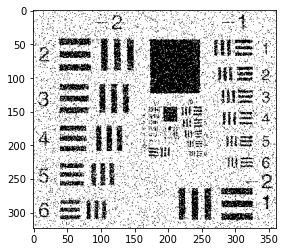

100%|██████████| 90/90 [02:28<00:00,  1.65s/it]


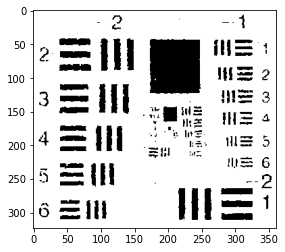

In [44]:
# Program the simulated annealing 
#temperature initialization 
import tqdm
T=100
beta_reg=2*(var0)*s
#initialization of the binary image
im_bin = im_thresh.copy()
plt.imshow(im_bin);
plt.show()
#affiche(im_bin)

# make a loop by calling the function that does a Gibbs sampling at T
for n in tqdm.tqdm(range(90)):
    im_bin=echan_r(im_bin,im_obs,beta_reg,m0,m1,T)
    T = 0.99*T #temperature update 
    #plt.imshow(im_bin);
    #plt.show(block=False)
plt.figure()
plt.imshow(im_bin);
plt.show()
    
    

I wanted to plot the image at each iteration, but i got the error at the 264 image: "Buffered data was truncated after reaching the output size limit."

###Q14
Compare the results obtained by the Iterated Conditional Modes algorithm and by simulated annealing. Do you find the results of the course ?

###A14

Yes, indeed the alghoritm is very slow with respect to ICM one. Depending on the number of iteration we want the time required can vary a lot, for 1000 iteration Anneling took 45 minutes to end, for 90 iteration 2 minutes and 30 seconds. ICM algorithm tooks one minute and half. Also if T is not big enought we can have a problem of "math range error", but on the other had if it's too big, we cannot see any result.

As we  already anticipated in class, this method is very slow since it keeps decreasing T, keeping updating it! Since my update is very small, we require a big number of iteration for being able to see interesting results.
On the other hand we can loose less details with respect to ICM, we can indeed see that the reconstructed value are much more defined than the one in ICM,but for achiving a very good result the number of iteration should be higher!

At the beggining the im_bin is: 

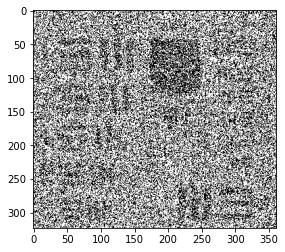

After 1000 iterations, with $\beta$=10, initial T=1000 the result is: 

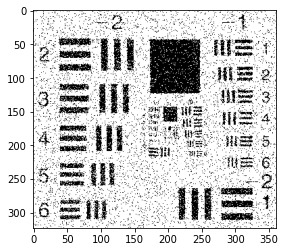

After 1000 iterations, with $\beta$=10, initial T=100 the result is:

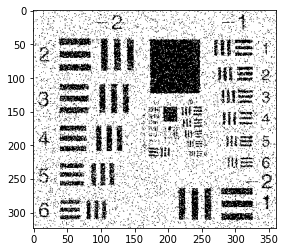

After 1000 iterations, with $\beta$=100, initial T=100 the result is:

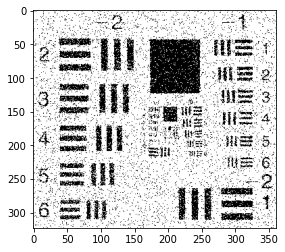


After 90 iterations, with $\beta$ =2000, initial T=100 the result is:

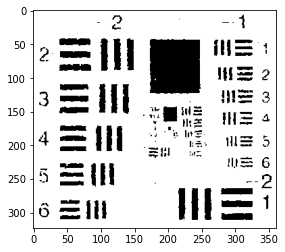